In [10]:
import sys, os
import numpy as np
sys.path.append('../src/')
import torch
from mgnn.MolGraphNetwork import MolGraphNetwork
from utils import find_repo_root
from scf_guess_tools import Backend
from scf_guess_datasets import Qm9

project_root_dir = find_repo_root()
print("Project root directory:", project_root_dir)
BASIS_PATH = "../../../scripts/6-31g_2df_p_custom_nwchem.gbs"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)




Project root directory: /home/etschgi1/REPOS/Masterarbeit
Using device: cpu


In [11]:
local_pc_path = os.path.join(project_root_dir, "datasets/QM9") if str(device) != "cuda" else "/home/dmilacher/datasets/data1"
dataset = Qm9(
    local_pc_path, 
    size = 500, # number of molecules to load
    val=0.1, # using 80% training / 10 % val / 10% test split
    test=0.1
)


In [12]:
MGNN = MolGraphNetwork(dataset=dataset,
                       basis=BASIS_PATH,
                       backend=Backend.PY,
                       batch_size=8,
                       hidden_dim=256,
                       message_net_layers=3,
                       message_passing_steps=2,
                       edge_threshold_val=2.73,
                       message_net_dropout=0.10,
                       target="density",
                       data_aug_factor=1,
                       verbose_level=2)
MGNN.load_data()

Setting verbose level to: 2
Loading 500 files from qm9...
Loading 400 files for train set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9/xyz...
Loading 50 files for val set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9/xyz...
Loading 50 files for test set from /home/etschgi1/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9/xyz...


Creating training graphs: 400it [00:04, 88.91it/s] 
Creating validation graphs: 50it [00:00, 197.66it/s]
Creating test graphs: 50it [00:00, 193.49it/s]


Total samples: 500, Train: 400, Val: 50, Test: 50
Found 5 center keys (['C', 'F', 'H', 'N', 'O']) and 15 edge keys (['C_C', 'C_F', 'C_H', 'C_N', 'C_O', 'F_F', 'F_H', 'F_N', 'F_O', 'H_H', 'H_N', 'H_O', 'N_N', 'N_O', 'O_O']) in the training set. -> Totaling 20 unique encoder/decoder.
Normalization factors computed and applied.
Center stats: {'C': (0.08893045239638739, 0.27210393758102036), 'F': (0.08822716789537685, 0.27078562814452456), 'H': (0.3772194703420003, 0.4689655636092979), 'N': (0.08836812201218727, 0.2711008247167218), 'O': (0.08820201116919178, 0.2707920626400333)}, Edge stats: {'C_C': (0.0009770245723731415, 0.06833880214406937), 'C_F': (-0.0002567330508316459, 0.06537002236662247), 'C_H': (0.008218945443186292, 0.10157528352664245), 'C_N': (0.0008033426312936548, 0.07293465091251518), 'C_O': (0.00041504397745895804, 0.06605982474347342), 'F_F': (-0.00045282814795783826, 0.026389934504852313), 'F_H': (0.0006138705807049531, 0.013804777283103718), 'F_N': (-0.0006938521862779

In [ ]:
RETRAIN = False  
model_name = "gnn_full_test"
if not RETRAIN and os.path.exists(f"{project_root_dir}/3_studies/Block_guessing/6-31g_full_testing/models/{model_name}.pth"):
    MGNN.load_model(f"{project_root_dir}/3_studies/Block_guessing/6-31g_full_testing/models/{model_name}.pth")
else:
    epoch, _ = MGNN.train_model(num_epochs=100, lr=0.00268, weight_decay=1.78e-5, grace_epochs=10, model_save_path=f"{project_root_dir}/3_studies/Block_guessing/6-31g_full_testing/models/{model_name}.pth", loss_on_full_matrix=True)
    MGNN.save_model(f"{project_root_dir}/3_studies/Block_guessing/6-31g_full_testing/models/{model_name}.pth", epoch=epoch)
MGNN.get_last_epoch()

Loaded weights from /home/ewachmann/REPOS/Masterarbeit/3_studies/Block_guessing/6-31g_full_testing/models/gnn_full_test.pth (strict=True)


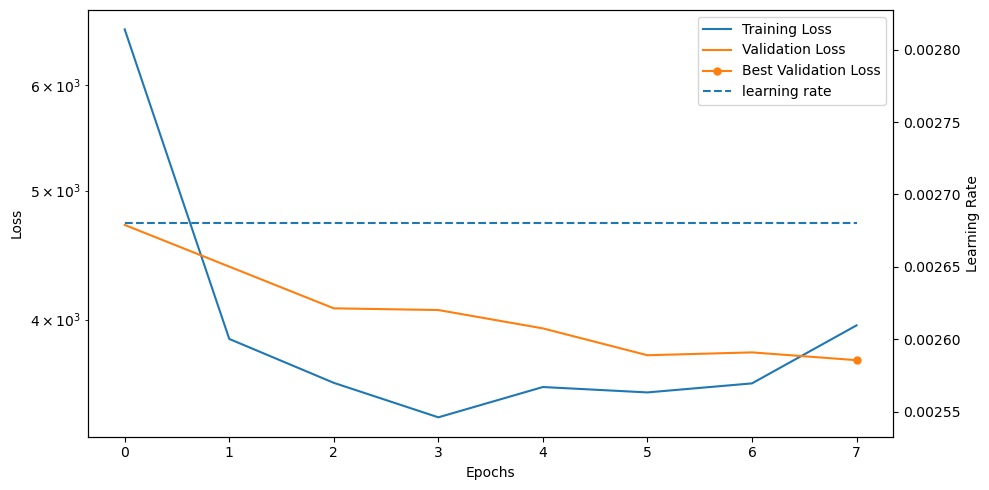

In [5]:
import pickle
from matplotlib import pyplot as plt
with open(f"{project_root_dir}/3_studies/Block_guessing/6-31g_full_testing/models/{model_name}.history", "rb") as f: 
    hist = pickle.load(f)
# hist["train_loss"]
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(hist["train_loss"], label="Training Loss", color="tab:blue")
ax.plot(hist["val_loss"], label="Validation Loss", color="tab:orange")
ax.plot(np.array(hist["val_loss"]).argmin(), hist["val_loss"][np.array(hist["val_loss"]).argmin()],
         marker="o", markersize=5, color="tab:orange", label="Best Validation Loss")
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
ax.set_yscale("log")
ax2 = ax.twinx()
ax2.plot(hist["lr"], linestyle="--", label="learning rate")
ax2.set_ylabel("Learning Rate")
ax2.tick_params(axis='y')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper right")
plt.tight_layout()
plt.show()

In [13]:
test_graphs = MGNN.get_graphs("test")

Testing on random sample with id 34


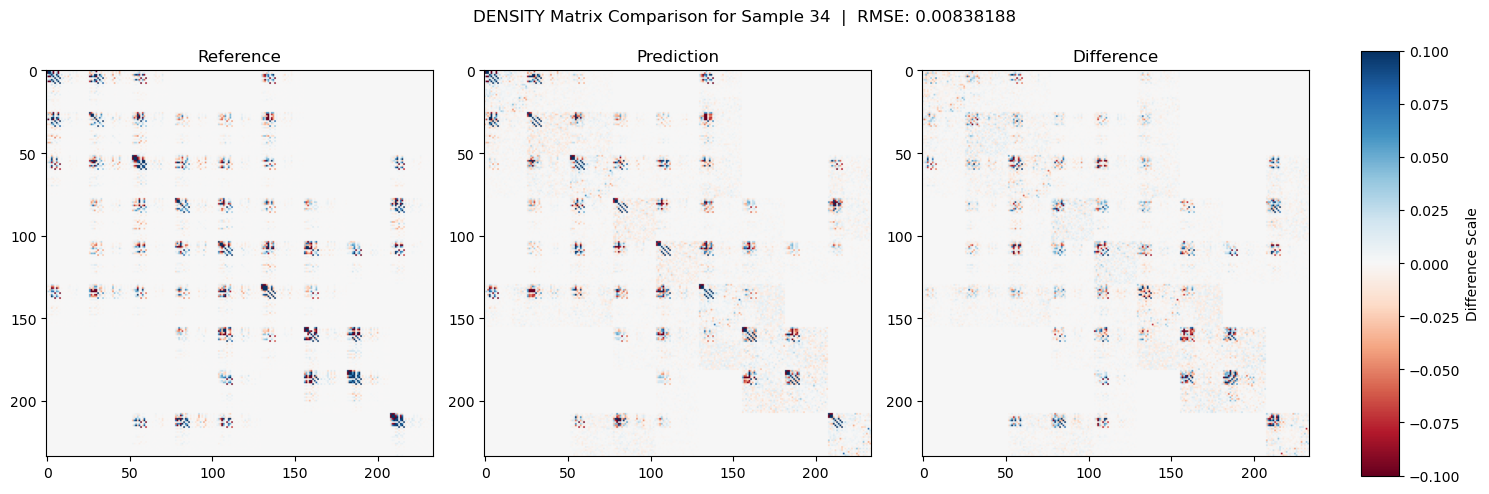

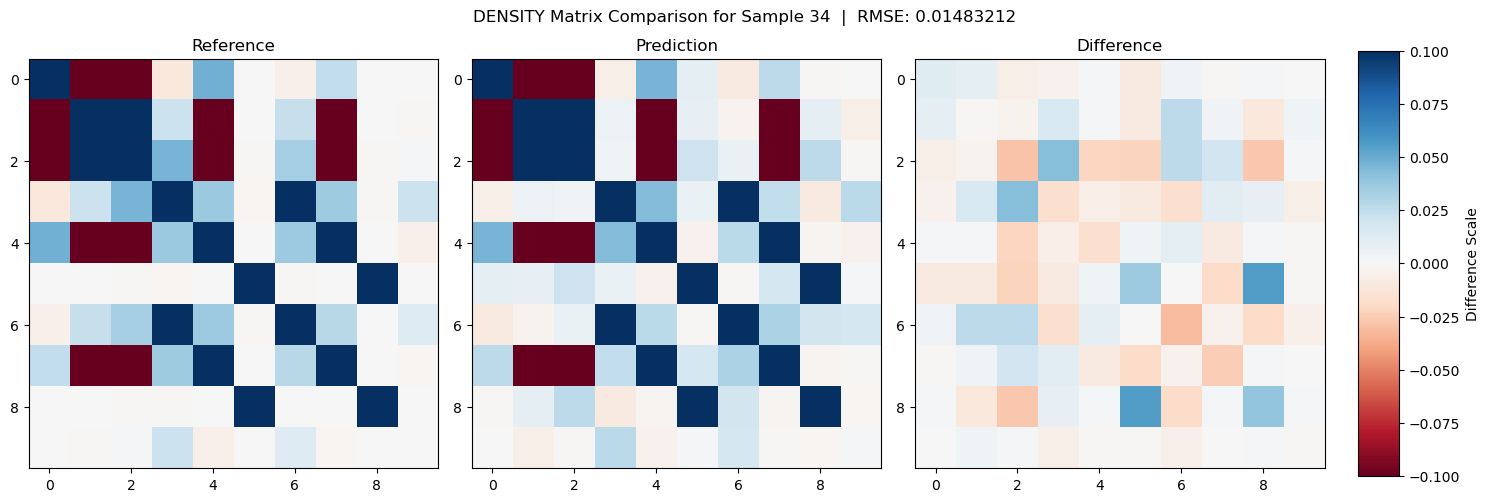

In [12]:
# aux code for testing
sys.path.append('../../')
from utils import plot_mat_comp

randsample_id = np.random.randint(0, len(test_graphs))
print(f"Testing on random sample with id {randsample_id}")
test_graph = test_graphs[randsample_id]
density_pred, density_truth = MGNN.predict([test_graph], include_target=True, transform_to_density=True)[0]
plot_mat_comp(density_truth, density_pred, 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)
plot_mat_comp(density_truth[:10,:10], density_pred[:10,:10], 
                     title=f"DENSITY Matrix Comparison for Sample {randsample_id}", vmax=0.1)

ok this already look pretty good for very few training runs!

In [14]:
from scf_guess_tools import load, calculate, guess
from scipy.linalg import eigh
from pyscf import gto, scf

In [ ]:
# default calc using minao guess!
rand_file = MGNN.get_files("test")[randsample_id]
print(rand_file)
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_minao = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess="minao")

/home/ewachmann/REPOS/Masterarbeit/scf_guess_datasets/scf_guess_datasets/qm9_isomeres/xyz/dsC7O2H10nsd_4415.xyz
Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.108160684644


In [ ]:
density_pred = density_pred.astype(np.float64)

In [ ]:
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_own = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=density_pred)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.108160685003


In [ ]:
# ground truth guess
mol = load(rand_file, basis=BASIS_PATH, backend=Backend.PY)
wf_gt = calculate(mol, basis=BASIS_PATH, method="dft", functional="b3lypg", guess=density_truth)

Using basis from ../../../scripts/6-31g_2df_p_custom_nwchem.gbs
converged SCF energy = -423.10816068506


In [ ]:
cycles_minao, cycles_own, cycles_gt = wf_minao.native.cycles, wf_own.native.cycles, wf_gt.native.cycles
print(f"Cycles with minao guess: {cycles_minao}, cycles with own guess: {cycles_own}, cycles with ground truth guess: {cycles_gt}")

Cycles with minao guess: 10, cycles with own guess: 13, cycles with ground truth guess: 13


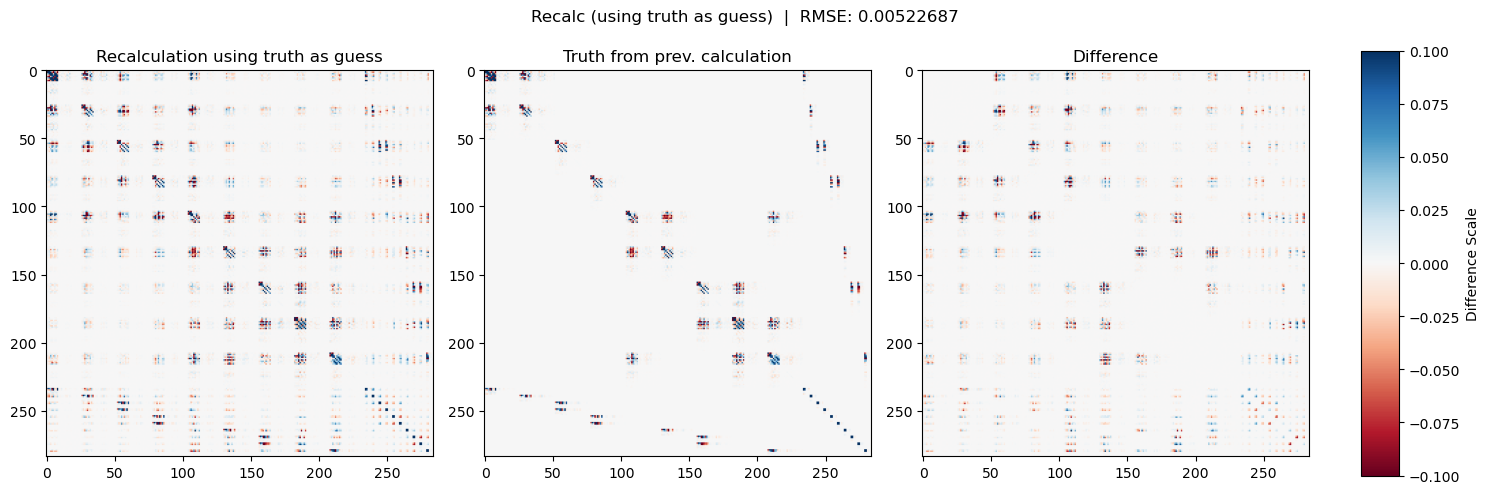

In [ ]:
plot_mat_comp(wf_minao._D, density_truth, title="Recalc (using truth as guess)", ref_title="Recalculation using truth as guess", pred_title="Truth from prev. calculation", vmax=0.1)

# Iteration Benchmark

In [16]:
from time import time
from uncertainties import ufloat
import scf_guess_datasets

In [7]:
start_time = time()
density_preds = MGNN.predict(test_graphs, include_target=False, transform_to_density=True)

pred_time = time() - start_time # stat benchmarking later
print(f"Prediction time for {len(test_graphs)} samples: {pred_time:.2f} seconds - {pred_time/len(test_graphs):.4f} seconds per sample")

files = MGNN.get_files("test")
print(f"Number of test files: {len(files)}")

cycles =  []
print("Testing for iteration count")

Prediction time for 50 samples: 1.01 seconds - 0.0202 seconds per sample
Number of test files: 50
Testing for iteration count


In [16]:
# own 
test_keys = dataset.test_keys # only use half of the validation set -> which is the test set used by the model!
for i, density_pred in enumerate(density_preds):
    solver = dataset.solver(test_keys[i])
    overlap, hcore, density, fock, status = scf_guess_datasets.solve(solver, density_pred.astype(np.float64))
    cycles.append(status.iterations)
    print(f"Sample {i}: Cycles with own guess: {status.iterations}")


Sample 0: Cycles with own guess: 16


KeyboardInterrupt: 

# Iterations benchmark

In [5]:
import pickle
mean_own = np.mean(cycles)
std_own = np.std(cycles)
iter_own = ufloat(mean_own, std_own)
print(f"Average iterations with own guess: {iter_own:.2f}")
with open(f"{project_root_dir}/3_studies/Block_guessing/6-31g_md_testing/models/{model_name}_cycles.pkl", "wb") as f:
    pickle.dump(cycles, f)

NameError: name 'cycles' is not defined

In [17]:
scheme_iterations = {dataset.schemes[i]: [] for i in range(len(dataset.schemes))}
for key in dataset.test_keys: #! only use half of the validation set -> which is the test set used by the model!
    for scheme, sample in dataset.guesses(key).items():
        scheme_iterations[scheme].append(sample.status.iterations)
for scheme, iterations in scheme_iterations.items():
    print(f"{scheme}: {np.mean(iterations):.2f} +- {np.std(iterations):.2f} iterations")

1e: 18.66 +- 2.84 iterations
vsap: 13.96 +- 1.73 iterations
sap: 15.82 +- 2.41 iterations
minao: 11.06 +- 1.14 iterations


# Energy benchmark

In [18]:
from pyscf import gto, dft

def create_mf_from_mol(mol: gto.Mole, xc: str = "b3lyp") -> dft.RKS:
    mf = dft.RKS(mol)
    mf.xc = xc
    mf.grids.build()  # ensures XC grid is initialized
    return mf

def build_fock_from_density(mf: dft.RKS, density):
    vj, vk = mf.get_jk(dm=density)
    vxc = mf.get_veff(mf.mol, dm=density)
    hcore = mf.get_hcore()
    return hcore + vj + vxc - 0.5 * vk
def energy_elec(fock, density, coreH): 
    return np.trace((fock+coreH) @ density)

def energy_err(e_pred, e_conv): 
    return e_conv - e_pred, e_pred/e_conv -1

In [19]:
from scf_guess_datasets import solve


In [20]:
# build all fock matrices
pred_focks = []
pred_overlaps = []
for i, pred_density in enumerate(density_preds):
    cur_mol = dataset.molecule(dataset.test_keys[i])
    mf = create_mf_from_mol(cur_mol, xc="b3lypg")
    pred_focks.append(build_fock_from_density(mf, pred_density))
    pred_overlaps.append(mf.get_ovlp())
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Energy error is expected to be very high if one compares this to conv sol!

In [26]:
# dummy model
densities, focks, overlaps = [], [], []
for key in dataset.train_keys: 
    sample = dataset.solution(key)
    densities.append(sample.density)
    focks.append(sample.fock)
    overlaps.append(sample.overlap)
dummy_densities = np.mean(np.array(densities), axis=0)
dummy_focks = np.mean(np.array(focks), axis=0)
dummy_overlaps = np.mean(np.array(overlaps), axis=0)

In [23]:
energy_metrics = {dataset.schemes[i]: {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]} for i in range(len(dataset.schemes))}
energy_metrics["own"] = {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]}
energy_metrics["dummy"] = {"energy_conv":[], "energy_guess":[], "abs_err":[], "rel_err":[]}
for own, key in zip((density_preds, pred_focks), dataset.test_keys): #! only use half of the validation set -> which is the test set used by the model!
    energy_conv = energy_elec(dataset.solution(key).fock, dataset.solution(key).density, dataset.solution(key).hcore)
    for scheme, sample in dataset.guesses(key).items():
        e_pred = energy_elec(sample.fock, sample.density, sample.hcore)
        err, rel_err = energy_err(e_pred, energy_conv)
        energy_metrics[scheme]["abs_err"].append(err)
        energy_metrics[scheme]["rel_err"].append(rel_err)
        energy_metrics[scheme]["energy_conv"].append(energy_conv)
        energy_metrics[scheme]["energy_guess"].append(e_pred)
    # own
    # e_pred = energy_elec(own[1], own[0], sample.hcore)
    # err, rel_err = energy_err(e_pred, energy_conv)
    # energy_metrics["own"]["abs_err"].append(err)
    # energy_metrics["own"]["rel_err"].append(rel_err)
    # energy_metrics["own"]["energy_conv"].append(energy_conv)
    # energy_metrics["own"]["energy_guess"].append(e_pred)
    # # 0D
    # e_pred = energy_elec(dummy_focks, dummy_densities, sample.hcore)
    # err, rel_err = energy_err(e_pred, energy_conv)
    # energy_metrics["dummy"]["abs_err"].append(err)
    # energy_metrics["dummy"]["rel_err"].append(rel_err)
    # energy_metrics["dummy"]["energy_conv"].append(energy_conv)
    # energy_metrics["dummy"]["energy_guess"].append(e_pred)



for scheme, metrics in energy_metrics.items():
    abs_err = np.mean(metrics["abs_err"])
    rel_err = np.mean(metrics["rel_err"])
    print(scheme)
    print(f"{abs_err:.5f} +- {np.std(metrics['abs_err']):.5f}")
    print(f"{rel_err:.8f} +- {np.std(metrics['rel_err']):.8f}")
    # print(f"{scheme}: Mean Absolute Error: {abs_err:.6f}, Mean Relative Error: {rel_err:.6f}")
    # print(f"Energy Conv: {np.mean(metrics['energy_conv']):.6f}, Energy Guess: {np.mean(metrics['energy_guess']):.6f}")

1e
-224.57854 +- 3.58759
-0.12361695 +- 0.00285359
vsap
-4.84189 +- 0.00038
-0.00266487 +- 0.00001916
sap
-14.03878 +- 0.92156
-0.00772301 +- 0.00045225
minao
2.86535 +- 0.02009
0.00157694 +- 0.00000016
own
nan +- nan
nan +- nan
dummy
nan +- nan
nan +- nan


# DIIS Error

In [24]:
def diis_rmse(overlap, density, fock): 
    """Eq 2.3 - Milacher"""
    E = fock @ density @ overlap - overlap @ density @ fock
    diis_rmse_ = np.sqrt(np.linalg.norm(E, ord='fro')**2 / (density.shape[0]**2))
    return diis_rmse_

In [25]:
diis_metrics = {
    scheme: [] for scheme in dataset.schemes
}
diis_metrics["own"] = []  # for the own guess
diis_metrics["dummy"] = []  # for the dummy guess
diis_metrics["conv"] = []  # for the converged solution

for key in dataset.test_keys:  # only test split
    conv_diis = diis_rmse(dataset.solution(key).overlap, dataset.solution(key).density, dataset.solution(key).fock)
    diis_metrics["conv"].append(conv_diis)
    guesses = dataset.guesses(key)
    for scheme, sample in guesses.items():
        val = diis_rmse(sample.overlap, sample.density, sample.fock)
        diis_metrics[scheme].append(val)
    # own
    # own_diis = diis_rmse(pred_overlaps[key - 450], density_preds[key - 450], pred_focks[key - 450])
    # diis_metrics["own"].append(own_diis)
    # # 0D
    # dummy_diis = diis_rmse(dummy_overlaps, dummy_densities, dummy_focks)
    # diis_metrics["dummy"].append(dummy_diis)


for scheme, values in diis_metrics.items():
    print(f"{scheme}: Mean DIIS RMSE: {np.mean(values):.10f} {np.std(values):.10f}")
    print(np.median(values))

1e: Mean DIIS RMSE: 0.1217546089 0.0145380662
0.12062923681197049
vsap: Mean DIIS RMSE: 0.0236731399 0.0034767550
0.024234342452250895
sap: Mean DIIS RMSE: 0.0388043480 0.0069883509
0.03829994345443971
minao: Mean DIIS RMSE: 0.0811016401 0.0119012545
0.07713970661989031
own: Mean DIIS RMSE: nan nan
nan
dummy: Mean DIIS RMSE: nan nan
nan
conv: Mean DIIS RMSE: 0.0000001869 0.0000001218
1.5774392257279215e-07


# RMSE

In [27]:
rmse_metric = {
    scheme: [] for scheme in dataset.schemes
}
rmse_metric["own"] = []  # for the own guess
rmse_metric["dummy"] = []  # for the dummy guess

for key in dataset.test_keys:
    for scheme, sample in dataset.guesses(key).items():
        val = np.sqrt(np.mean((sample.density - dataset.solution(key).density)**2))
        rmse_metric[scheme].append(val)
    # own
    # own_rmse = np.sqrt(np.mean((density_preds[key - 450] - dataset.solution(key).density)**2))
    # rmse_metric["own"].append(own_rmse)
    # # 0D
    # dummy_rmse = np.sqrt(np.mean((dummy_densities - dataset.solution(key).density)**2))
    # rmse_metric["dummy"].append(dummy_rmse)

for scheme, values in rmse_metric.items():
    print(f"{scheme}: Mean RMSE: {np.mean(values):.5f} {np.std(values):.5f}")


1e: Mean RMSE: 0.16048 0.12245
vsap: Mean RMSE: 0.01055 0.00138
sap: Mean RMSE: 0.01514 0.00232
minao: Mean RMSE: 0.01723 0.00322
own: Mean RMSE: nan nan
dummy: Mean RMSE: nan nan
